In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col, when
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [2]:
spark = SparkSession.builder.appName("AirQualityAnalysisIndia").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/11/07 11:11:47 WARN Utils: Your hostname, Karthikeya, resolves to a loopback address: 127.0.1.1; using 172.17.54.10 instead (on interface wlp1s0)
25/11/07 11:11:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/07 11:11:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('hdfs://localhost:9000/air_quality_data/city_day.csv', header=True, inferSchema=True)

In [4]:
df.show(5)

+---------+----------+----+----+----+-----+-----+----+----+-----+------+-------+-------+------+----+----------+
|     City|      Date|PM25|PM10|  NO|  NO2|  NOx| NH3|  CO|  SO2|    O3|Benzene|Toluene|Xylene| AQI|AQI_Bucket|
+---------+----------+----+----+----+-----+-----+----+----+-----+------+-------+-------+------+----+----------+
|Ahmedabad|2015-01-01|NULL|NULL|0.92|18.22|17.15|NULL|0.92|27.64|133.36|    0.0|   0.02|   0.0|NULL|      NULL|
|Ahmedabad|2015-01-02|NULL|NULL|0.97|15.69|16.46|NULL|0.97|24.55| 34.06|   3.68|    5.5|  3.77|NULL|      NULL|
|Ahmedabad|2015-01-03|NULL|NULL|17.4| 19.3| 29.7|NULL|17.4|29.07|  30.7|    6.8|   16.4|  2.25|NULL|      NULL|
|Ahmedabad|2015-01-04|NULL|NULL| 1.7|18.48|17.97|NULL| 1.7|18.59| 36.08|   4.43|  10.14|   1.0|NULL|      NULL|
|Ahmedabad|2015-01-05|NULL|NULL|22.1|21.42|37.76|NULL|22.1|39.33| 39.31|   7.01|  18.89|  2.78|NULL|      NULL|
+---------+----------+----+----+----+-----+-----+----+----+-----+------+-------+-------+------+----+----

In [5]:
df.groupBy('AQI_Bucket').count().show()

+------------+-----+
|  AQI_Bucket|count|
+------------+-----+
|        NULL| 4681|
|        Good| 1341|
|      Severe| 1338|
|   Very Poor| 2337|
|Satisfactory| 8224|
|        Poor| 2781|
|    Moderate| 8829|
+------------+-----+



In [6]:
df = df.na.drop(how='any', subset=['AQI'])

In [7]:
df = df.drop('City', 'Date', 'AQI')

In [8]:
indexer = StringIndexer(inputCol="AQI_Bucket", outputCol="label")
indexer_model = indexer.fit(df)
df = indexer_model.transform(df)

In [9]:
feature_columns = [col for col in df.columns if col not in ['AQI_Bucket', 'label', 'Xylene']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid='skip')
df = assembler.transform(df)

In [10]:
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [11]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label")

## Finding best Hyper-Parameters

In [12]:
paramGrid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 50, 100])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.maxBins, [32, 64])
    .addGrid(rf.impurity, ['gini', 'entropy'])
    .build())

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3  # or 5 for more reliability
)

In [13]:
cvModel = cv.fit(train_data)

# Best model
best_model = cvModel.bestModel
print("Best numTrees:", best_model.getNumTrees)
print("Best maxDepth:", best_model.getOrDefault("maxDepth"))
print("Best impurity:", best_model.getOrDefault("impurity"))

25/11/03 01:06:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/03 01:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1031.0 KiB
25/11/03 01:06:34 WARN DAGScheduler: Broadcasting large task binary with size 1118.4 KiB
25/11/03 01:06:37 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1031.0 KiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1666.8 KiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1952.4 KiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/11/03 01:06:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/03 01:06:3

Best numTrees: 100
Best maxDepth: 15
Best impurity: entropy


## Model with best Hyper-Parameters

In [12]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100, maxDepth=15, impurity='gini', seed=819)
best_model = rf.fit(train_data)

25/11/07 11:12:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/07 11:12:12 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
25/11/07 11:12:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
25/11/07 11:12:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/11/07 11:12:15 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
25/11/07 11:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1274.8 KiB
25/11/07 11:12:17 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
25/11/07 11:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1520.5 KiB
25/11/07 11:12:18 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
25/11/07 11:12:19 WARN DAGScheduler: Broadcasting large task binary with size 1635.1 KiB
25/11/07 11:12:20 WARN 

In [13]:
predictions = best_model.transform(test_data)

## Model Analysis

In [15]:
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1 = f1_evaluator.evaluate(predictions)

print("\nperformance of Random Forest on test dataset")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-Score : {f1:.4f}")

25/11/07 11:13:10 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
25/11/07 11:13:12 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
25/11/07 11:13:13 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
25/11/07 11:13:14 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB



performance of Random Forest on test dataset
Accuracy : 0.8286
Precision: 0.8284
Recall   : 0.8286
F1-Score : 0.8279


/home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/BdaEnv/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
25/11/07 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
25/11/07 11:13:17 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


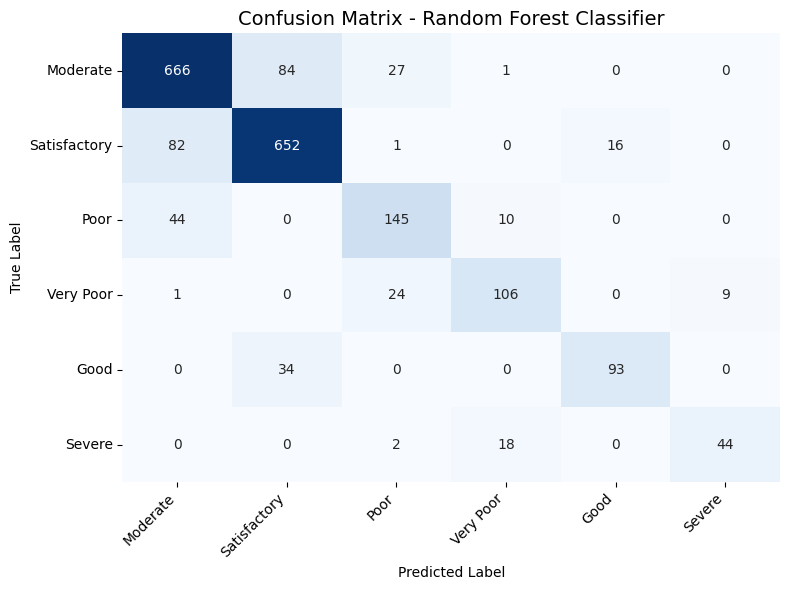

In [16]:
prediction_and_labels = predictions.select("prediction", "label").rdd.map(lambda r: (float(r[0]), float(r[1])))
metrics = MulticlassMetrics(prediction_and_labels)
conf_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Random Forest Classifier", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

labels = indexer_model.labels
plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, ha="right")
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.tight_layout()
plt.show()


In [17]:
label_converter = IndexToString(inputCol="prediction", outputCol="predicted_AQI_Bucket", labels=indexer_model.labels)
predictions = label_converter.transform(predictions)

predictions.select("predicted_AQI_Bucket", "AQI_Bucket", "features").show()

25/11/07 11:13:19 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


+--------------------+------------+--------------------+
|predicted_AQI_Bucket|  AQI_Bucket|            features|
+--------------------+------------+--------------------+
|                Good|        Good|[1.25,9.1,11.7,0....|
|                Good|        Good|[2.0,17.99,1.29,1...|
|                Good|        Good|[2.33,6.33,11.68,...|
|                Good|        Good|[3.43,7.24,11.61,...|
|                Good|        Good|[3.93,6.85,11.51,...|
|                Good|        Good|[4.49,8.9,11.7,0....|
|        Satisfactory|Satisfactory|[5.08,8.16,13.55,...|
|                Good|        Good|[5.48,9.88,11.53,...|
|                Good|        Good|[6.15,8.99,13.16,...|
|                Good|        Good|[6.24,12.61,2.92,...|
|                Good|        Good|[6.3,17.76,1.09,1...|
|                Good|        Good|[6.32,11.92,11.56...|
|        Satisfactory|Satisfactory|[6.48,22.89,7.13,...|
|                Good|        Good|[6.56,8.7,0.29,0....|
|                Good|Satisfact

In [18]:
df_pred_year = spark.read.parquet('file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/output/forecast_results/')

In [19]:
df_pred_year.show(5)

+---------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|     City|               Date|           Benzene|                CO|               NH3|               NO|               NO2|               NOx|                O3|              PM10|             PM25|               SO2|          Toluene|
+---------+-------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+
|Hyderabad|2016-02-15 00:00:00|0.7161830450003105|0.9984908445874056|16.918579741889488|9.281138816893062| 20.92588632883367|23.096103274919187|37.474054960538844|111.53776599864673|78.71194635308957| 7.524538634440478| 4.19614663636612|
|Hyderabad|2016-02-16 00:00:00|0.792318571778722

In [20]:
feature_columns = [col for col in df_pred_year.columns if col not in ['City','Date']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid='skip')
df_pred_year = assembler.transform(df_pred_year)

In [21]:
predictions = best_model.transform(df_pred_year)
label_converter = IndexToString(inputCol="prediction", outputCol="predicted_AQI_Bucket", labels=indexer_model.labels)
predictions = label_converter.transform(predictions)

In [22]:
predictions.groupBy('predicted_AQI_Bucket').count().show()

25/11/07 11:13:25 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


+--------------------+-----+
|predicted_AQI_Bucket|count|
+--------------------+-----+
|                Good| 1043|
|        Satisfactory|  609|
|                Poor|   13|
|            Moderate|37356|
+--------------------+-----+



25/11/07 11:13:26 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


In [23]:
predictions.write.mode("overwrite").parquet("file:///home/karthikeya/Desktop/sem5/MIT_SEM5_BDA/MiniProject/output/aqi_forecast/")

25/11/07 11:13:28 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB


In [24]:
spark.stop()